In [70]:
#Importing Libraries
import numpy as np 
import pandas as pd 
import torch
import pprint
from collections import Counter
import random
import IPython
from IPython.display import Image, Audio
from IPython.core.display import display
from PIL import Image as PILImage
import music21
from music21 import *
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

import os
import sys

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.seed(420)

In [32]:
from torch.utils.data import Dataset, DataLoader
import torch.functional as F
from sklearn.model_selection import train_test_split
#from tensorflow.keras.utils import to_categorical

import torch
import torch.nn as nn
import torch.optim as optim

In [33]:
us = environment.UserSettings()
#us.create()

In [34]:
#filepath = "./Dataset/DATASETGROSSO/ATTENTOADAPRIRE/Unhinged/"
filepath = "./Dataset/cleaned/"
#Getting midi files
all_midis= []
for i in os.listdir(filepath):
    if i.endswith(".mid"):
        tr = filepath+i
        midi = converter.parse(tr)
        all_midis.append(midi)

In [35]:
#Helping function        
def extract_notes(file):
    notes = []
    pick = None
    for j in file:
        songs = instrument.partitionByInstrument(j)
        for part in songs.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(str(n) for n in element.normalOrder))

    return notes
#Getting the list of notes as Corpus
Corpus= extract_notes(all_midis)
print("Total notes in all the Chopin midis in the dataset:", len(Corpus))

Total notes in all the Chopin midis in the dataset: 15193


In [36]:
print(Corpus[1:4])

['B-3', 'B-2', 'B-2']


In [37]:
# Storing all the unique characters present in my corpus to bult a mapping dic. 
symb = sorted(list(set(Corpus)))

L_corpus = len(Corpus) #length of corpus
L_symb = len(symb) #length of total unique characters

#Building dictionary to access the vocabulary from indices and vice versa
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", L_corpus)
print("Number of unique characters:", L_symb)

Total number of characters: 15193
Number of unique characters: 303


In [38]:
mapped_corpus = [mapping[element] for element in Corpus]

In [39]:
class MusicDataset(Dataset):
    def __init__(self, corpus, mapping, length=60):
        self.length = length
        self.mapping = mapping
        self.corpus = corpus
        self.features, self.targets = self.preprocess_data(corpus)
        self.L_symb = len(set(mapping.values()))

    def preprocess_data(self, corpus):
        features = []
        targets = []
        L_corpus = len(corpus)
        for i in range(0, L_corpus - self.length, 1):
            feature = corpus[i:i + self.length]
            target = corpus[i + self.length]
            features.append([self.mapping[j] for j in feature])
            targets.append(self.mapping[target])
        return np.array(features), np.array(targets)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        feature = self.features[idx]
        target = self.targets[idx]
        feature = np.reshape(feature, (self.length, 1)) / float(self.L_symb)
        target = to_categorical(target, num_classes=self.L_symb)
        return torch.tensor(feature, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)

In [78]:
class MusicDataset2(Dataset):
    def __init__(self, corpus, mapping, reverse_mapping, length=40):
        self.length = length
        self.mapping = mapping
        self.reverse = reverse_mapping
        self.corpus = corpus
        self.features, self.targets = self.preprocess_data(corpus)
        self.L_symb = len(set(mapping.values()))

    def preprocess_data(self, corpus):
        features = []
        targets = []
        L_corpus = len(corpus)
        for i in range(0, L_corpus - self.length, 1):
            feature = corpus[i:i + self.length]
            target = corpus[i + self.length]
            features.append(feature)
            targets.append(target)
        return np.array(features), np.array(targets)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        feature = self.features[idx]
        target = self.targets[idx]
        feature = np.reshape(feature, (self.length, 1)) / float(self.L_symb)
        target = to_categorical(target, num_classes=self.L_symb)
        #target = F.one_hot(torch.tensor(target,dtype=torch.float32), num_classes=self.L_symb)
        return torch.tensor(feature, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)

In [79]:
print("First fifty values in the Corpus:", Corpus[:50])

First fifty values in the Corpus: ['D3', 'E4', 'A3', 'D3', 'D4', 'A3', 'D3', 'E4', 'D3', 'D3', 'D4', 'E-4', 'E-4', 'D4', 'A3', 'G3', 'A3', 'D3', 'E4', 'A3', 'D3', 'D4', 'A3', 'D3', 'E4', 'D3', 'D3', 'D4', 'E-4', 'E-4', 'D4', 'A3', 'G3', 'A3', 'D3', 'D4', 'A3', 'D3', 'A3', 'D4', 'D4', 'D3', 'A3', 'D4', 'A3', 'D3', 'D4', 'D4', 'D4', 'D3']


In [80]:
#First Lets write some functions that we need to look into the data
def show(music):
    display(Image(str(music.write("musicxml.png"))))
    
def chords_n_notes(Snippet):
    Melody = []
    offset = 0 #Incremental
    for i in Snippet:
        #If it is chord
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".") #Seperating the notes in chord
            notes = [] 
            for j in chord_notes:
                inst_note=int(j)
                note_snip = note.Note(inst_note)            
                notes.append(note_snip)
                chord_snip = chord.Chord(notes)
                chord_snip.offset = offset
                Melody.append(chord_snip)
        # pattern is a note
        else: 
            note_snip = note.Note(i)
            note_snip.offset = offset
            Melody.append(note_snip)
        # increase offset each iteration so that notes do not stack
        offset += 1
    Melody_midi = stream.Stream(Melody)   
    return Melody_midi

Melody_Snippet = chords_n_notes(Corpus[:100])
#show(Melody_Snippet)

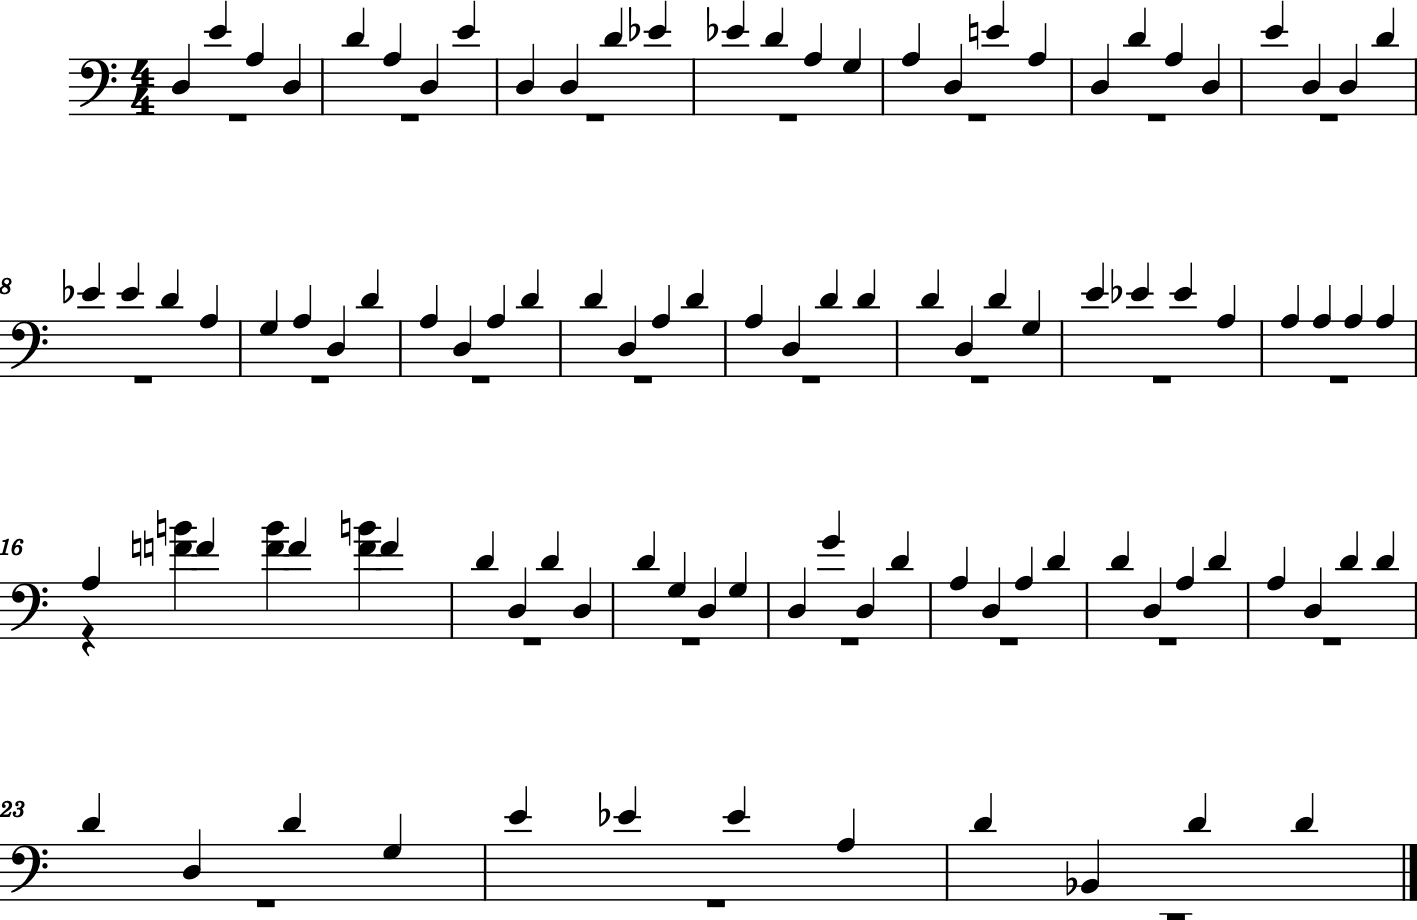

In [81]:
# Step 1: Write the music to a PNG file
image_path = Melody_Snippet.write("musicxml.png")

# Step 2: Open the PNG file with Pillow
original = PILImage.open(image_path)

# Step 3: Create a new image with a white background
white_background = PILImage.new("RGB", original.size, (255, 255, 255))

# Step 4: Paste the original image onto the white background
white_background.paste(original, (0, 0), original)

# Step 5: Save the new image
new_image_path = "musicxml_white_bg.png"
white_background.save(new_image_path)

# Display the new image in the Jupyter notebook
display(Image(new_image_path))


In [82]:
#Creating a count dictionary
count_num = Counter(Corpus)
print("Total unique notes in the Corpus:", len(count_num))

Total unique notes in the Corpus: 222


In [83]:

#Exploring the notes dictionary
Notes = list(count_num.keys())
Recurrence = list(count_num.values())
#Average recurrenc for a note in Corpus
def Average(lst):
    return sum(lst) / len(lst)
print("Average recurrenc for a note in Corpus:", Average(Recurrence))
print("Most frequent note in Corpus appeared:", max(Recurrence), "times")
print("Least frequent note in Corpus appeared:", min(Recurrence), "time")

Average recurrenc for a note in Corpus: 54.369369369369366
Most frequent note in Corpus appeared: 513 times
Least frequent note in Corpus appeared: 1 time


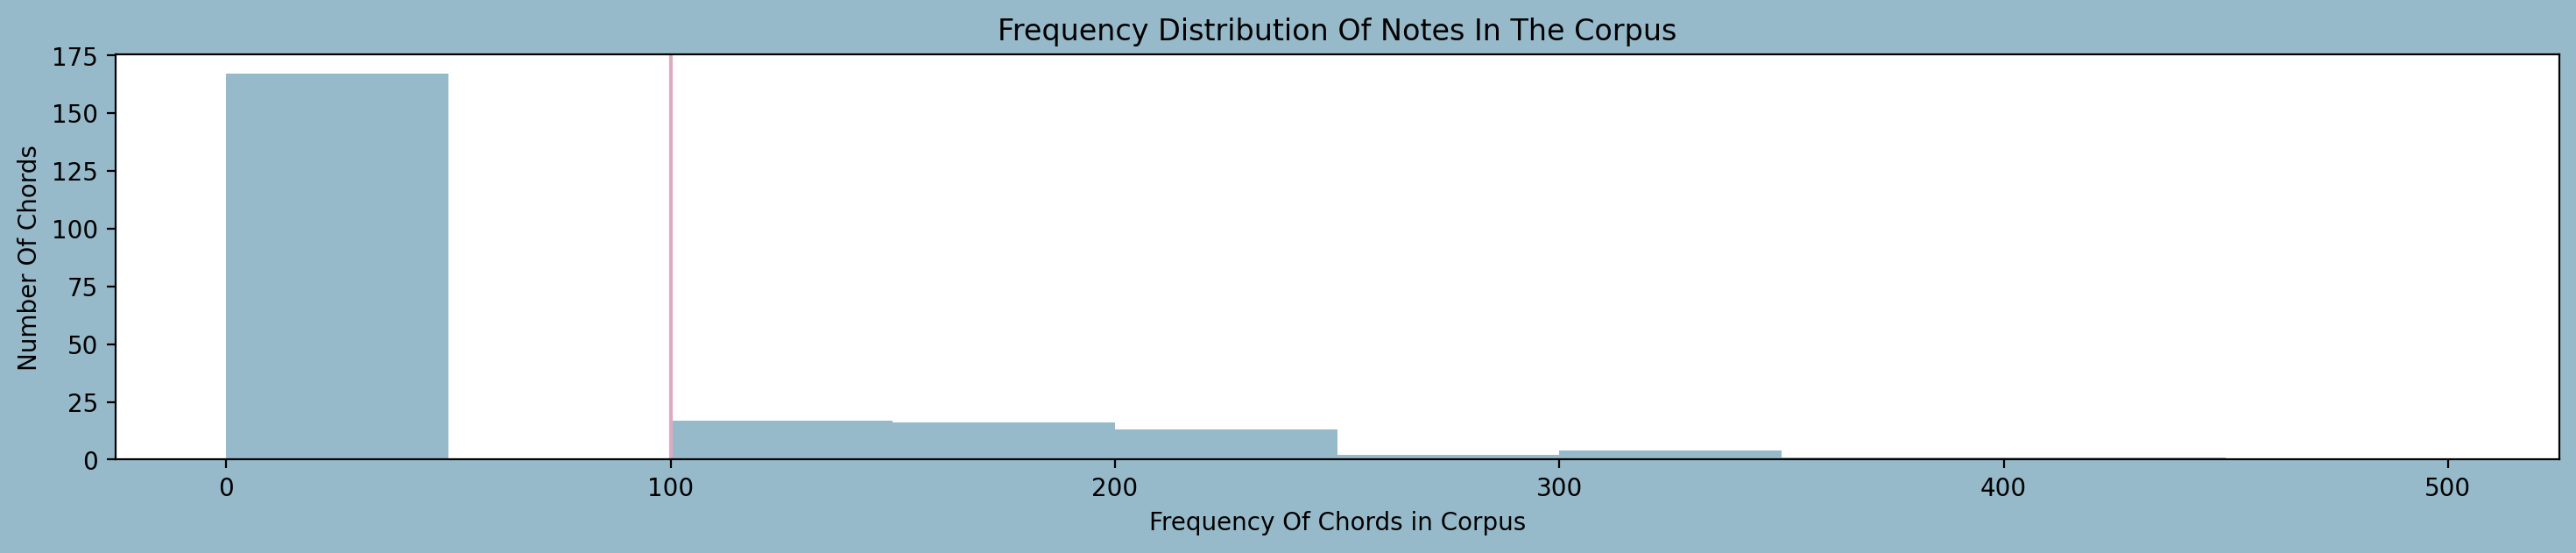

In [84]:
# Plotting the distribution of Notes
plt.figure(figsize=(18,3),facecolor="#97BACB")
bins = np.arange(0,(max(Recurrence)), 50) 
plt.hist(Recurrence, bins=bins, color="#97BACB")
plt.axvline(x=100,color="#DBACC1")
plt.title("Frequency Distribution Of Notes In The Corpus")
plt.xlabel("Frequency Of Chords in Corpus")
plt.ylabel("Number Of Chords")
plt.show()

In [85]:
#Getting a list of rare chords
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 100:
        m =  key
        rare_note.append(m)
        
print("Total number of notes that occur less than 100 times:", len(rare_note))

Total number of notes that occur less than 100 times: 167


In [86]:
#Eleminating the rare notes
for element in Corpus:
    if element in rare_note:
        Corpus.remove(element)

print("Length of Corpus after elemination the rare notes:", len(Corpus))

Length of Corpus after elemination the rare notes: 11159


In [87]:
corpus = Corpus
mapping = mapping

#dataset = MusicDataset(corpus, mapping)
dataset = MusicDataset2(mapped_corpus, mapping,reverse_mapping)

# Create train and validation splits
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create DataLoaders for train and validation sets
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [88]:
first_batch = next(iter(train_loader))
#print(first_batch[1])
# Check the first batch
for inputs, labels in train_loader:
    #print("Inputs:", inputs[0])
    print("Labels:", labels[0])
    break

Labels: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 

In [89]:
class MusicLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(MusicLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_dim, hidden_dim1, batch_first=True, dropout=0.1)
        self.lstm2 = nn.LSTM(hidden_dim1, hidden_dim2, batch_first=True)
        self.dropout = nn.Dropout(0.1)
        self.dense1 = nn.Linear(hidden_dim2, 256)
        self.dense2 = nn.Linear(256, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.dropout(x)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]  # Take the last time step output
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.dense2(x)
        x = self.softmax(x)
        return x

In [90]:
# Assuming X_train has shape (num_samples, length, 1)
input_dim = 1  # Number of input features (same as X_train.shape[2])
hidden_dim1 = 512
hidden_dim2 = 256
output_dim = len(mapping)  # Number of output classes (same as y_train.shape[1])

model = MusicLSTM(input_dim, hidden_dim1, hidden_dim2, output_dim)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()


#optimizer = optim.Adamax(model.parameters(), lr=0.01)
optimizer = optim.RMSprop(model.parameters(), lr=0.01)

In [91]:
num_epochs = 50  # Define the number of epochs

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode 
    running_loss = 0.0

    # Create a progress bar for batches
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
        for inputs, targets in train_loader:
            optimizer.zero_grad()  # Clear the gradients

            # Forward pass
            outputs = model(inputs)

            # Calculate the loss
            #loss = criterion(outputs, torch.argmax(targets, dim=1))
            loss = criterion(outputs, targets)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Update the progress bar
            pbar.set_postfix(loss=running_loss / (pbar.n + 1))
            pbar.update(1)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

Epoch 1/50:   0%|          | 0/190 [00:00<?, ?batch/s]

Epoch 1/50: 100%|██████████| 190/190 [00:27<00:00,  6.90batch/s, loss=5.7]


Epoch [1/50], Loss: 5.6963


Epoch 2/50: 100%|██████████| 190/190 [00:27<00:00,  7.01batch/s, loss=5.7] 


Epoch [2/50], Loss: 5.6962


Epoch 3/50: 100%|██████████| 190/190 [00:27<00:00,  6.84batch/s, loss=5.7] 


Epoch [3/50], Loss: 5.6961


Epoch 4/50: 100%|██████████| 190/190 [00:28<00:00,  6.63batch/s, loss=5.7]


Epoch [4/50], Loss: 5.6961


Epoch 5/50: 100%|██████████| 190/190 [00:27<00:00,  6.86batch/s, loss=5.7]


Epoch [5/50], Loss: 5.6961


Epoch 6/50: 100%|██████████| 190/190 [00:28<00:00,  6.71batch/s, loss=5.7] 


Epoch [6/50], Loss: 5.6961


Epoch 7/50: 100%|██████████| 190/190 [00:27<00:00,  6.83batch/s, loss=5.7] 


Epoch [7/50], Loss: 5.6961


Epoch 8/50: 100%|██████████| 190/190 [00:30<00:00,  6.33batch/s, loss=5.7] 


Epoch [8/50], Loss: 5.6962


Epoch 9/50: 100%|██████████| 190/190 [00:28<00:00,  6.62batch/s, loss=5.7]


Epoch [9/50], Loss: 5.6962


Epoch 10/50: 100%|██████████| 190/190 [00:28<00:00,  6.74batch/s, loss=5.7]


Epoch [10/50], Loss: 5.6962


Epoch 11/50: 100%|██████████| 190/190 [00:28<00:00,  6.76batch/s, loss=5.7] 


Epoch [11/50], Loss: 5.6962


Epoch 12/50: 100%|██████████| 190/190 [00:29<00:00,  6.42batch/s, loss=5.7]


Epoch [12/50], Loss: 5.6960


Epoch 13/50: 100%|██████████| 190/190 [00:29<00:00,  6.45batch/s, loss=5.7]


Epoch [13/50], Loss: 5.6961


Epoch 14/50: 100%|██████████| 190/190 [00:29<00:00,  6.55batch/s, loss=5.7] 


Epoch [14/50], Loss: 5.6960


Epoch 15/50: 100%|██████████| 190/190 [00:28<00:00,  6.73batch/s, loss=5.7]


Epoch [15/50], Loss: 5.6961


Epoch 16/50: 100%|██████████| 190/190 [00:31<00:00,  6.07batch/s, loss=5.7]


Epoch [16/50], Loss: 5.6961


Epoch 17/50: 100%|██████████| 190/190 [00:28<00:00,  6.66batch/s, loss=5.7] 


Epoch [17/50], Loss: 5.6962


Epoch 18/50: 100%|██████████| 190/190 [00:29<00:00,  6.43batch/s, loss=5.7]


Epoch [18/50], Loss: 5.6962


Epoch 19/50: 100%|██████████| 190/190 [00:28<00:00,  6.78batch/s, loss=5.7]


Epoch [19/50], Loss: 5.6962


Epoch 20/50: 100%|██████████| 190/190 [00:29<00:00,  6.53batch/s, loss=5.7]


Epoch [20/50], Loss: 5.6960


Epoch 21/50: 100%|██████████| 190/190 [00:26<00:00,  7.08batch/s, loss=5.7] 


Epoch [21/50], Loss: 5.6958


Epoch 22/50: 100%|██████████| 190/190 [00:26<00:00,  7.30batch/s, loss=5.7] 


Epoch [22/50], Loss: 5.6960


Epoch 23/50: 100%|██████████| 190/190 [00:26<00:00,  7.29batch/s, loss=5.7]


Epoch [23/50], Loss: 5.6962


Epoch 24/50: 100%|██████████| 190/190 [00:25<00:00,  7.31batch/s, loss=5.7]


Epoch [24/50], Loss: 5.6962


Epoch 25/50:  95%|█████████▍| 180/190 [00:25<00:01,  6.98batch/s, loss=5.7] 


KeyboardInterrupt: 

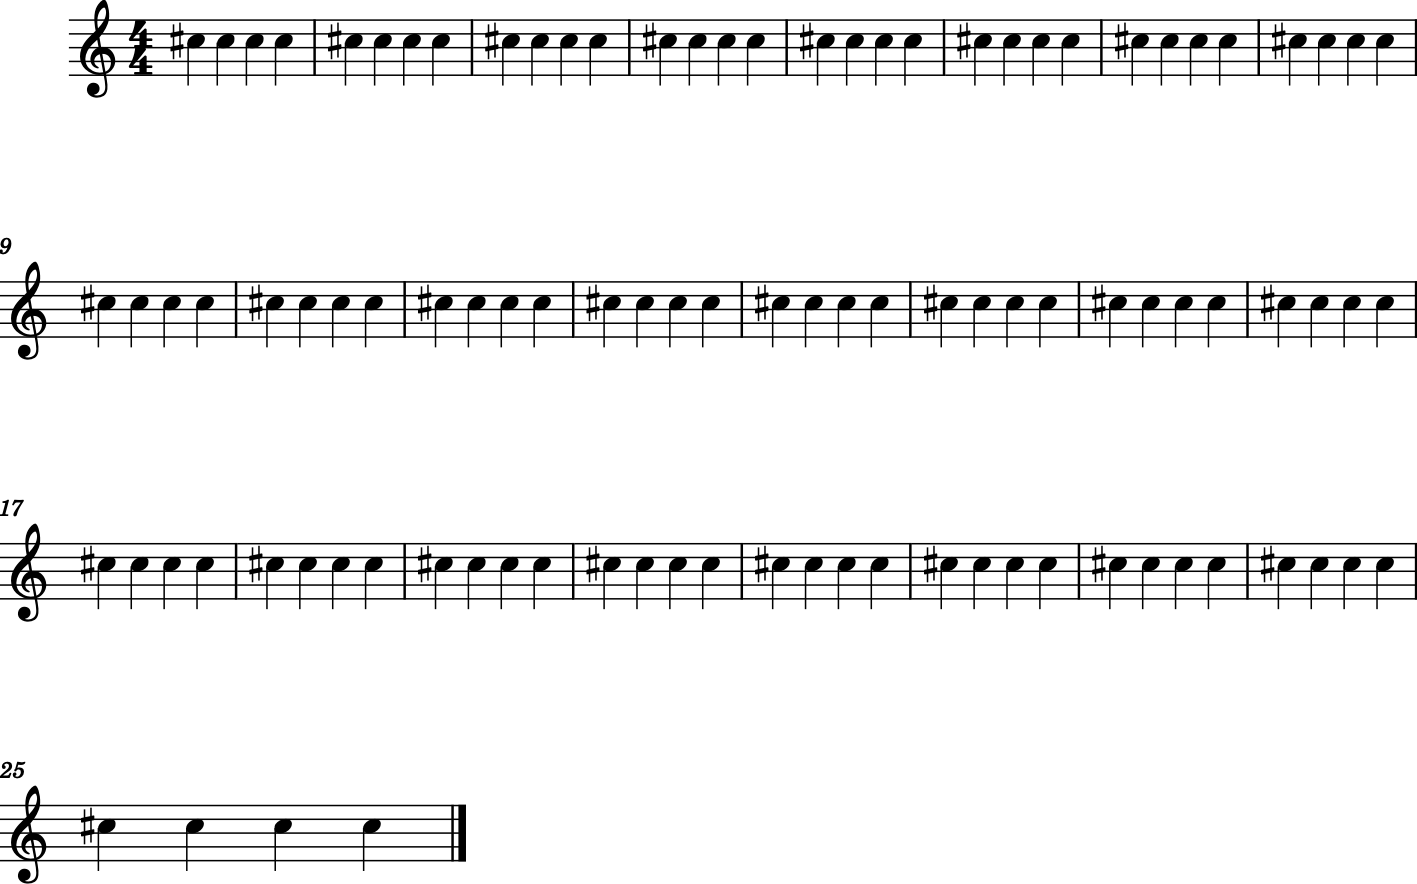

In [ ]:
def Malody_Generator(Note_Count, model, val_dataset, length, vocab_size, reverse_mapping, device='cpu'):
    # Choose a random seed from val_dataset
    seed_idx = np.random.randint(0, len(val_dataset) - 1)
    seed, _ = val_dataset[seed_idx]
    seed = seed.numpy()

    Music = ""
    Notes_Generated = []
    
    for i in range(Note_Count):
        seed_tensor = torch.tensor(seed, dtype=torch.float32).view(1, length, 1).to(device)
        
        model.eval()
        with torch.no_grad():
            prediction = model(seed_tensor)
        
        prediction = prediction.cpu().numpy()[0]
        prediction = np.log(prediction) / 1.0  # diversity
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        
        index = np.argmax(prediction)
        index_N = index / float(vocab_size)
        
        Notes_Generated.append(index)
        Music = [reverse_mapping[char] for char in Notes_Generated]
        
        seed = np.insert(seed, len(seed), index_N)
        seed = seed[1:]
    
    Melody = chords_n_notes(Music)
    Melody_midi = stream.Stream(Melody)
    
    return Music, Melody_midi

# Generate and display the melody
Music_notes, Melody = Malody_Generator(
    Note_Count=100,
    model=model,
    val_dataset=val_dataset,
    length=40,  # Adjust based on your sequence length
    vocab_size=len(mapping),
    reverse_mapping=reverse_mapping,
    device='cpu'
)

Melody.show()


In [ ]:
Melody.write('midi','Melody_Generated.mid')
def beep():
    display(Audio('./Melody_Generated.mid', autoplay=True))
beep()

In [ ]:
sp = midi.realtime.StreamPlayer(Melody)
#sp.play()

AttributeError: 'Score' object has no attribute 'realtime'